-----------------------------------------------------------------------------

<h1> MOFs CO2 working capacity prediction with XGBoost </h1>

------------------------------------------------------------

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from boostaroota import BoostARoota
from IPython.core.display import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_absolute_error

<h2>loading dataset</h2>

In [19]:
df = pd.read_csv('Datasets/cif_xyz_nonfg_train.csv');df

,MOFname,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,mof_unit_2,2769.503842,1.326090,2211.697211,603.6100,0.13794,0.1040,F-OMe,10,44,...,-0.600769,-3.410680,18.641128,173,71,35,67,194,5.150000e-09,0.000001
1,mof_unit_3,1089.818728,1.178856,773.687960,788.5000,0.14874,0.1262,OMe-COOH,2,22,...,0.010529,0.148108,10.630959,80,32,14,34,82,-3.660000e-08,-0.000003
2,mof_unit_4,2205.198301,0.982408,1304.638720,1441.5300,0.21814,0.2220,H-SO3H,9,17,...,-0.078915,-6.446998,18.164659,107,56,23,28,112,4.460000e-08,0.000005
3,mof_unit_6,3954.659761,0.647909,1543.027680,2430.5500,0.37094,0.5725,Pr-NO2,9,7,...,-2.470500,-0.012234,22.470616,158,72,24,62,164,-1.830000e-08,-0.000003
4,mof_unit_7,3565.914939,0.910268,1954.749656,1530.0200,0.33337,0.3662,NH2,10,53,...,0.012840,-4.025383,22.428988,165,68,28,69,182,2.200000e-08,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68579,mof_unit_68607,949.067112,1.318868,753.787520,164.5781,0.00000,0.0000,Pr,2,10,...,4.211774,-0.032201,15.139554,84,38,8,38,86,-3.490000e-08,-0.000003
68580,mof_unit_68608,1202.182553,1.440028,1042.538240,161.0412,0.00000,0.0000,Ph-Cl,3,12,...,-0.709510,-0.700082,11.090143,100,56,8,36,104,3.850000e-08,0.000004
68581,mof_unit_68609,1188.302573,1.399781,1001.700216,150.9874,0.00000,0.0000,Pr-F,3,4,...,-0.398622,-0.155104,10.184892,110,47,8,55,119,3.360000e-08,0.000004
68582,mof_unit_68610,1506.660363,1.645811,1493.296496,161.4001,0.01108,0.0000,SO3H,10,42,...,-2.389941,-1.681765,14.747027,115,38,27,50,126,-5.560000e-08,-0.000007


seperate label column

In [20]:
df = df.drop(df[df['void_fraction'] <=0].index,axis=0)
df.reset_index(inplace=True)
df

,index,MOFname,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,0,mof_unit_2,2769.503842,1.326090,2211.697211,603.6100,0.13794,0.1040,F-OMe,10,...,-0.600769,-3.410680,18.641128,173,71,35,67,194,5.150000e-09,1.000000e-06
1,1,mof_unit_3,1089.818728,1.178856,773.687960,788.5000,0.14874,0.1262,OMe-COOH,2,...,0.010529,0.148108,10.630959,80,32,14,34,82,-3.660000e-08,-3.000000e-06
2,2,mof_unit_4,2205.198301,0.982408,1304.638720,1441.5300,0.21814,0.2220,H-SO3H,9,...,-0.078915,-6.446998,18.164659,107,56,23,28,112,4.460000e-08,5.000000e-06
3,3,mof_unit_6,3954.659761,0.647909,1543.027680,2430.5500,0.37094,0.5725,Pr-NO2,9,...,-2.470500,-0.012234,22.470616,158,72,24,62,164,-1.830000e-08,-3.000000e-06
4,4,mof_unit_7,3565.914939,0.910268,1954.749656,1530.0200,0.33337,0.3662,NH2,10,...,0.012840,-4.025383,22.428988,165,68,28,69,182,2.200000e-08,4.000000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65653,68554,mof_unit_68582,1108.951518,1.409824,941.517200,156.1297,0.01790,0.0127,SO3H-OPr,3,...,0.042300,0.293986,9.906940,82,36,16,30,88,4.550000e-08,4.000000e-06
65654,68562,mof_unit_68590,2981.283155,1.464359,2629.066240,166.8738,0.00486,0.0000,Cl-CN,9,...,1.634405,0.000158,36.424586,196,132,28,36,212,-1.420000e-08,-3.000000e-06
65655,68566,mof_unit_68594,1524.505449,1.835401,1685.041936,160.9308,0.00699,0.0000,NO2-Br,10,...,-1.829472,-2.088027,14.660987,114,40,28,46,128,8.240000e-18,-6.660000e-16
65656,68568,mof_unit_68596,3760.489888,1.476275,3343.200672,122.7019,0.01221,0.0000,NHMe-H,10,...,-2.272441,0.038326,8.337153,296,96,48,152,332,1.180000e-17,1.780000e-15


In [21]:
df_label = df['CO2_working_capacity']
df = df.drop(['CO2_working_capacity','MOFname'],axis=1)
print(df.shape,' : ',df_label.shape);df

(65658, 36)  :  (65658,)


,index,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,0,2769.503842,1.326090,2211.697211,603.6100,0.13794,0.1040,F-OMe,10,44,...,-0.600769,-3.410680,18.641128,173,71,35,67,194,5.150000e-09,1.000000e-06
1,1,1089.818728,1.178856,773.687960,788.5000,0.14874,0.1262,OMe-COOH,2,22,...,0.010529,0.148108,10.630959,80,32,14,34,82,-3.660000e-08,-3.000000e-06
2,2,2205.198301,0.982408,1304.638720,1441.5300,0.21814,0.2220,H-SO3H,9,17,...,-0.078915,-6.446998,18.164659,107,56,23,28,112,4.460000e-08,5.000000e-06
3,3,3954.659761,0.647909,1543.027680,2430.5500,0.37094,0.5725,Pr-NO2,9,7,...,-2.470500,-0.012234,22.470616,158,72,24,62,164,-1.830000e-08,-3.000000e-06
4,4,3565.914939,0.910268,1954.749656,1530.0200,0.33337,0.3662,NH2,10,53,...,0.012840,-4.025383,22.428988,165,68,28,69,182,2.200000e-08,4.000000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65653,68554,1108.951518,1.409824,941.517200,156.1297,0.01790,0.0127,SO3H-OPr,3,14,...,0.042300,0.293986,9.906940,82,36,16,30,88,4.550000e-08,4.000000e-06
65654,68562,2981.283155,1.464359,2629.066240,166.8738,0.00486,0.0000,Cl-CN,9,18,...,1.634405,0.000158,36.424586,196,132,28,36,212,-1.420000e-08,-3.000000e-06
65655,68566,1524.505449,1.835401,1685.041936,160.9308,0.00699,0.0000,NO2-Br,10,46,...,-1.829472,-2.088027,14.660987,114,40,28,46,128,8.240000e-18,-6.660000e-16
65656,68568,3760.489888,1.476275,3343.200672,122.7019,0.01221,0.0000,NHMe-H,10,42,...,-2.272441,0.038326,8.337153,296,96,48,152,332,1.180000e-17,1.780000e-15


<h1>Normalizing</h1>

Normalizing functional groups

In [22]:
def check_in(pattern : str, loop : list or np.ndarray or None = df.functional_groups):
    return [int(pattern in str(x).split('-') )for x in loop]

def count_in(pattern : str, loop : list or np.ndarray or None = df.functional_groups):
    return [str(x).count(pattern) for x in loop]

compounds = set(['SO3H','COOH','NH2','OH','CN','F','OMe','NHMe','NO2','Pr','Cl','OEt','Ph','Br','OPr','HCO','Et','Me','H','I'])
molecules = set(['N','O','C'])

func_data = {
    f'funccheck_{compound}':check_in(compound)
    for compound in compounds
}
func_data.update({
    f'funccount_{molecule}':count_in(molecule)
    for molecule in molecules
})
func_data.update({
    'num_func': [int('-' in str(x)) for x in df.functional_groups]
})

df.functional_groups = df.functional_groups.astype("category").cat.codes
func_df = pd.DataFrame(func_data);func_df


,funccheck_NHMe,funccheck_OPr,funccheck_Pr,funccheck_NH2,funccheck_Br,funccheck_Ph,funccheck_OMe,funccheck_OEt,funccheck_HCO,funccheck_SO3H,...,funccheck_NO2,funccheck_Cl,funccheck_F,funccheck_Me,funccheck_I,funccheck_CN,funccount_O,funccount_C,funccount_N,num_func
0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,3,1,0,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65653,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,2,0,0,1
65654,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,2,1,1
65655,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1
65656,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


Add more feature

In [23]:
df.insert(
    loc=0,
    column='difatom',
    value=df['sumatom']-df['C+O+H']
)
df.insert(
    loc=0,
    column='surface_to_volume',
    value=df['surface_area']/df['volume']
)
df.insert(
    loc=0,
    column='cubic_surface_area',
    value=((df['volume']**(1/3))**2)*6
)
df

,cubic_surface_area,surface_to_volume,difatom,index,volume,density,weight,surface_area,void_fraction,void_volume,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,1183.275571,0.217949,21,0,2769.503842,1.326090,2211.697211,603.6100,0.13794,0.1040,...,-0.600769,-3.410680,18.641128,173,71,35,67,194,5.150000e-09,1.000000e-06
1,635.410072,0.723515,2,1,1089.818728,1.178856,773.687960,788.5000,0.14874,0.1262,...,0.010529,0.148108,10.630959,80,32,14,34,82,-3.660000e-08,-3.000000e-06
2,1016.520988,0.653696,5,2,2205.198301,0.982408,1304.638720,1441.5300,0.21814,0.2220,...,-0.078915,-6.446998,18.164659,107,56,23,28,112,4.460000e-08,5.000000e-06
3,1500.458542,0.614604,6,3,3954.659761,0.647909,1543.027680,2430.5500,0.37094,0.5725,...,-2.470500,-0.012234,22.470616,158,72,24,62,164,-1.830000e-08,-3.000000e-06
4,1400.442353,0.429068,17,4,3565.914939,0.910268,1954.749656,1530.0200,0.33337,0.3662,...,0.012840,-4.025383,22.428988,165,68,28,69,182,2.200000e-08,4.000000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65653,642.825294,0.140790,6,68554,1108.951518,1.409824,941.517200,156.1297,0.01790,0.0127,...,0.042300,0.293986,9.906940,82,36,16,30,88,4.550000e-08,4.000000e-06
65654,1242.853867,0.055974,16,68562,2981.283155,1.464359,2629.066240,166.8738,0.00486,0.0000,...,1.634405,0.000158,36.424586,196,132,28,36,212,-1.420000e-08,-3.000000e-06
65655,794.762263,0.105563,14,68566,1524.505449,1.835401,1685.041936,160.9308,0.00699,0.0000,...,-1.829472,-2.088027,14.660987,114,40,28,46,128,8.240000e-18,-6.660000e-16
65656,1450.933586,0.032629,36,68568,3760.489888,1.476275,3343.200672,122.7019,0.01221,0.0000,...,-2.272441,0.038326,8.337153,296,96,48,152,332,1.180000e-17,1.780000e-15


One-hotting metal/organic linkers and topology

In [24]:
metal_linker_int = df['metal_linker']-1
metal_one_hot = to_categorical(metal_linker_int,num_classes=12,dtype='int8')
metal_onehot_df = pd.DataFrame(metal_one_hot,columns=['ml_' + str(num) for num in range(1,13)])
print(metal_onehot_df.shape)
display(metal_onehot_df.head(2))
#---------------------------------------
org1_int = df['organic_linker1']-1
org1_one_hot = to_categorical(org1_int,num_classes=59,dtype='int8')
org1_onehot_df = pd.DataFrame(org1_one_hot,columns=['ol1_' + str(num) for num in range(1,60)])
print(org1_onehot_df.shape)
display(org1_onehot_df.head(2))
#--------------------------------------
org2_int = df['organic_linker2']-1
org2_one_hot = to_categorical(org2_int,num_classes=59,dtype='int8')
org2_onehot_df = pd.DataFrame(org2_one_hot,columns=['ol2_' + str(num) for num in range(1,60)])
print(org2_onehot_df.shape)
display(org2_onehot_df.head(2))
#--------------------------------------
top_int = df['topology']
top_one_hot = to_categorical(top_int,dtype='int8')
top_onehot_df = pd.DataFrame(top_one_hot,columns=['top_' + str(num) for num in range(0,11)])
print(top_onehot_df.shape)
display(top_onehot_df.head(2))

(65658, 12)


,ml_1,ml_2,ml_3,ml_4,ml_5,ml_6,ml_7,ml_8,ml_9,ml_10,ml_11,ml_12
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0


(65658, 59)


,ol1_1,ol1_2,ol1_3,ol1_4,ol1_5,ol1_6,ol1_7,ol1_8,ol1_9,ol1_10,...,ol1_50,ol1_51,ol1_52,ol1_53,ol1_54,ol1_55,ol1_56,ol1_57,ol1_58,ol1_59
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(65658, 59)


,ol2_1,ol2_2,ol2_3,ol2_4,ol2_5,ol2_6,ol2_7,ol2_8,ol2_9,ol2_10,...,ol2_50,ol2_51,ol2_52,ol2_53,ol2_54,ol2_55,ol2_56,ol2_57,ol2_58,ol2_59
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(65658, 11)


,top_0,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0


<h1>Feature selection</h1>

In [25]:
df_col = dict(
    df_geometry_col = [
    'surface_area',
    'void_fraction',
    'density',
    'void_volume',
    'weight',
    'volume',
    ],
    df_function_col = [
    'functional_groups',
    'metal_linker',
    'organic_linker1',
    'organic_linker2',
    'topology',
    'CO2/N2_selectivity',
    'heat_adsorption_CO2_P0.15bar_T298K',
    ],
    df_cif_col = [
    'cell_length_a',
    'cell_length_b',
    'cell_length_c',
    'cell_angle_alpha',
    'cell_angle_beta',
    'cell_angle_gamma',
    'sum_charge',
    # 'mean_charge',
    ],
    df_xyz_col = [
    'Lattice1', 
    # 'Lattice2',
    # 'Lattice3', 
    'Lattice4', 
    'Lattice5', 
    # 'Lattice6', 
    'Lattice7', 
    'Lattice8',
    'Lattice9', 
    # 'C+O+H', 
    'C', 
    'O', 
    'H', 
    'sumatom',
    ],
    df_add_col = [
    'surface_to_volume',
    'difatom',
    'cubic_surface_area'
    ]
)

df_selected = df[sum(df_col.values(),[])]
print(df_selected.shape)
df_selected = pd.concat([df_selected,metal_onehot_df,org1_onehot_df,org2_onehot_df,top_onehot_df,func_df],axis=1)
print(df_selected.shape);df_selected.head()

(65658, 33)
(65658, 198)


,surface_area,void_fraction,density,void_volume,weight,volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,funccheck_NO2,funccheck_Cl,funccheck_F,funccheck_Me,funccheck_I,funccheck_CN,funccount_O,funccount_C,funccount_N,num_func
0,603.61,0.13794,1.326090,0.1040,2211.697211,2769.503842,115,10,44,57,...,0,0,1,0,0,0,1,0,0,1
1,788.50,0.14874,1.178856,0.1262,773.687960,1089.818728,303,2,22,24,...,0,0,0,0,0,0,3,1,0,1
2,1441.53,0.21814,0.982408,0.2220,1304.638720,2205.198301,139,9,17,24,...,0,0,0,0,0,0,1,0,0,1
3,2430.55,0.37094,0.647909,0.5725,1543.027680,3954.659761,373,9,7,23,...,1,0,0,0,0,0,1,0,1,1
4,1530.02,0.33337,0.910268,0.3662,1954.749656,3565.914939,200,10,53,55,...,0,0,0,0,0,0,0,0,1,0


Feature selection with BoostARoota

In [26]:
# unimportant_col = ["top_7","ol2_59","ol2_39","ol2_37","ol2_34","ol2_33","ol2_32","ol1_58","ol1_57","ol1_37","ol1_33","ol1_31","ml_11","ml_8","ml_7","ml_6","ml_5"]
# df_selected = df_selected.drop(unimportant_col,axis=1)

<h2>convert to array</h2>

In [27]:
df_label_array = np.array(df_label)
df_array = np.array(df_selected)
f'{df_label_array.shape} : {df_array.shape}'

'(65658,) : (65658, 198)'

<h2>train-test split</h2>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_array,df_label_array,test_size=0.1,random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.15,random_state=123)
print(f'train : {X_train.shape}\nval : {X_val.shape}\ntest : {X_test.shape}')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_array,df_label_array,test_size=0.1,random_state=123)
print(f'train : {X_train.shape}\ntest : {X_test.shape}')

train : (59092, 198)
test : (6566, 198)


<h1> Model training </h1>

<h2> Model 1 -XGBoost</h2>

In [29]:
# xg_reg1 = xgb.XGBRegressor(
#     eta = 0.008,
#     seed = 123,
#     max_depth =10,
#     colsample_bytree =0.7,
#     min_child_weight = 6,
#     subsample = 0.7,
#     num_parallel_tree=10,
#     n_estimators = 20000,
#     tree_method='exact',
#     verbosity = 0,
#     )

In [34]:
xg_reg1 = xgb.XGBRegressor(
    eta = 0.1,
    seed = 123,
    max_depth =10,
    colsample_bytree =0.8,
    subsample = 0.8,
    min_child_weight = 6,
    num_parallel_tree=5,
    n_estimators = 600,
    tree_method='exact',
    verbosity = 2,
    )

In [35]:
xg_reg1.fit(
    X_train,
    y_train,
    # early_stopping_rounds = 10,
    # eval_metric='mae',
    # eval_set=[(X_val,y_val)]
    )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=8, num_parallel_tree=5, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=0)

In [36]:
pred = xg_reg1.predict(X_train);lmae_cheat = np.log(mean_absolute_error(y_train,pred));lmae_cheat

1.5228468223592861

In [39]:
pred = xg_reg1.predict(X_test);lmae = np.log(mean_absolute_error(y_test,pred));lmae

2.935335591681901

In [40]:
# xg_reg1.save_model("2914.json")
# xg_reg_load = xgb.Booster();xg_reg_load.load_model("2914.json")
# pred = xg_reg_load.predict(xgb.DMatrix(X_test));lmae = np.log(mean_absolute_error(y_test,pred));lmae

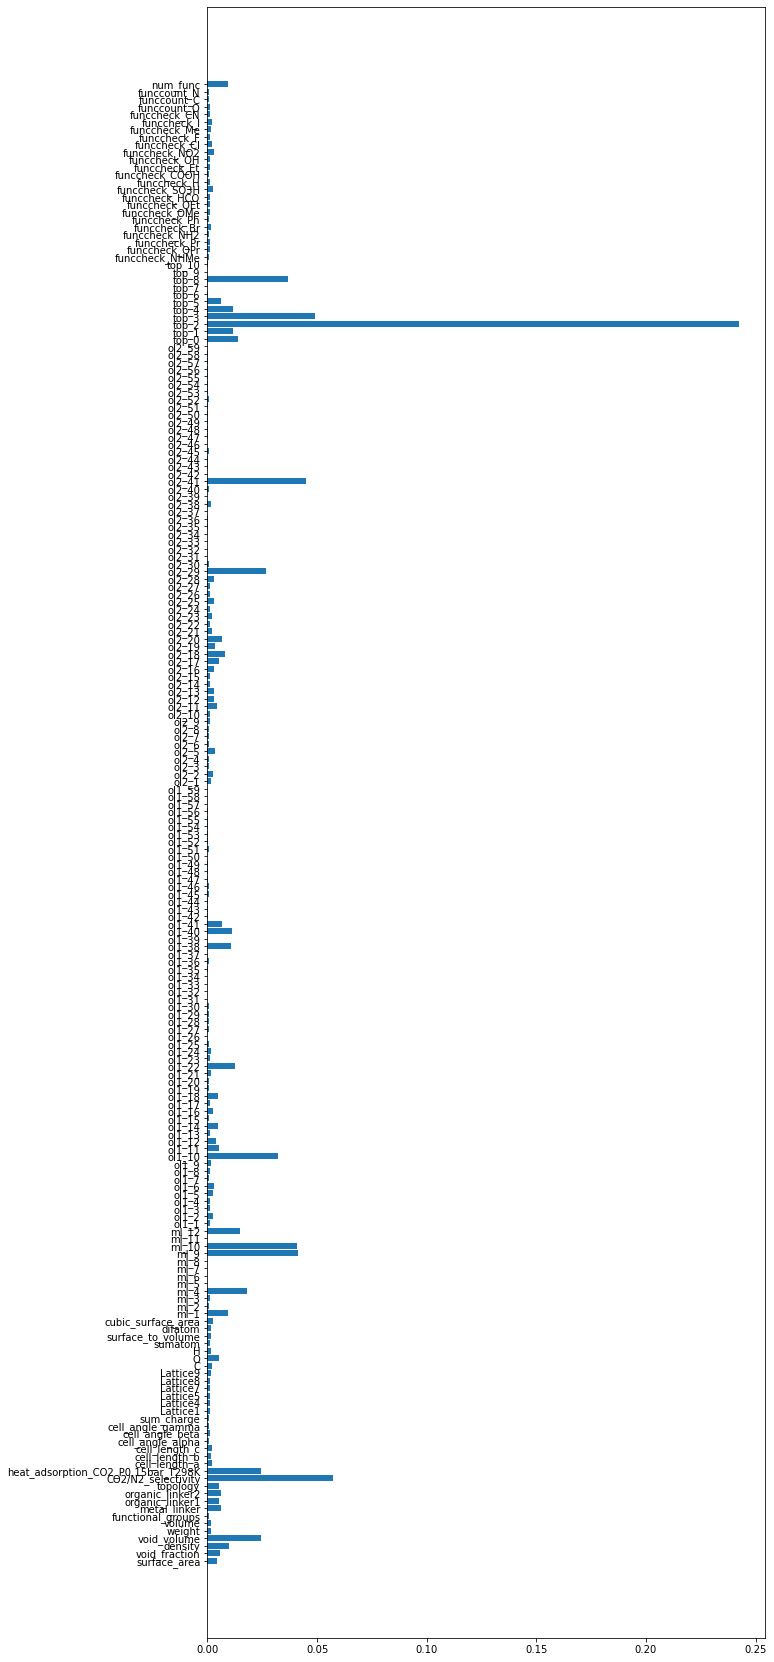

In [41]:
plt.figure(figsize=(10,30))
plt.barh(df_selected.columns, xg_reg1.feature_importances_);plt.show()

In [42]:
pred_df = pd.DataFrame([pred,y_test]).T;pred_df

,0,1
0,299.311615,285.661665
1,64.473610,61.298205
2,201.144531,135.912309
3,188.405899,236.057153
4,151.849564,189.958206
...,...,...
6561,-9.014945,-16.198136
6562,161.602112,142.476908
6563,136.258667,183.870513
6564,111.162437,139.804979


In [ ]:
%matplotlib inline
plt.scatter(pred_df[0],pred_df[1]-(pred_df[0]));plt.show()

In [ ]:
plt.scatter(pred_df[0],pred_df[1]);plt.show()

In [ ]:
# cheated_pred = dict();
# for i in np.arange(0.0001,0.01,0.0001):
#     pred = xg_reg1.predict(X_test)
#     lmae = np.log(mean_absolute_error(y_test,pred*(1-i)))
#     cheated_pred.update({i:lmae})
# min(cheated_pred.values())
# b = list(cheated_pred.keys())[list(cheated_pred.values()).index(min(cheated_pred.values()))]

<h1>Comparing</h1>

<BarContainer object of 3 artists>

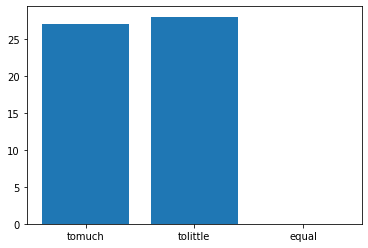

In [43]:
pred_df_plot = pred_df[pred_df[0]>400]
tomuch = len(pred_df_plot[(pred_df_plot[1]-pred_df_plot[0]).astype(int)<0])
tolittle = len(pred_df_plot[(pred_df_plot[1]-pred_df_plot[0]).astype(int)>0])
equal = len(pred_df_plot[(pred_df_plot[1]-pred_df_plot[0]).astype(int)==0])
plt.bar(['tomuch','tolittle','equal'],[tomuch,tolittle,equal])

<h1>Evaluation</h1>

In [44]:
testset = pd.read_csv('Datasets/cif_xyz_nonfg_test.csv')
print(testset.shape);testset.head()

(17000, 35)


,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,1208.301332,1.096273,797.70936,586.54,0.11392,0.1039,OEt,2,5,26,...,1.020099,0.251768,17.037858,82,34,14,34,84,-2.380000e-08,-0.000002
1,4126.414623,1.502488,3733.65779,852.49,0.21367,0.1422,H-I,4,6,17,...,-0.093270,-2.770419,27.516247,143,96,26,21,158,3.160000e-08,0.000005
2,1602.148373,0.774443,747.21048,3155.73,0.33883,0.4375,CN-OH,3,11,17,...,-0.039581,0.011104,10.019053,52,30,10,12,60,1.670000e-08,0.000001
3,2436.629312,0.678630,995.80232,3521.09,0.40464,0.5963,OMe,2,1,28,...,-0.463995,0.123045,23.456356,90,46,16,28,94,-4.260000e-08,-0.000004
4,3123.418006,0.711091,1337.53800,2678.46,0.38959,0.5479,NO2-Pr,3,8,19,...,-0.471207,0.882816,16.623692,100,42,28,30,118,-8.470000e-09,-0.000001


In [45]:
test_func_data = {
    f'funccheck_{compound}':check_in(compound,loop=testset.functional_groups)
    for compound in compounds
}
test_func_data.update({
    f'funccount_{molecule}':count_in(molecule,loop=testset.functional_groups)
    for molecule in molecules
})
test_func_data.update({
    'num_func': [int('-' in str(x)) for x in testset.functional_groups]
})
testset.functional_groups = testset.functional_groups.astype("category").cat.codes
test_func_df = pd.DataFrame(test_func_data);test_func_df.head(5)

,funccheck_NHMe,funccheck_OPr,funccheck_Pr,funccheck_NH2,funccheck_Br,funccheck_Ph,funccheck_OMe,funccheck_OEt,funccheck_HCO,funccheck_SO3H,...,funccheck_NO2,funccheck_Cl,funccheck_F,funccheck_Me,funccheck_I,funccheck_CN,funccount_O,funccount_C,funccount_N,num_func
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1


In [46]:
test_metal_linker_int = testset['metal_linker']-1
test_metal_one_hot = to_categorical(test_metal_linker_int,num_classes=12,dtype='int8')
test_metal_onehot_df = pd.DataFrame(test_metal_one_hot,columns=['ml_' + str(num) for num in range(1,13)])
display(test_metal_onehot_df.head(3))
#-------------------------------------------------
test_org1_int = testset['organic_linker1']-1
test_org1_one_hot = to_categorical(test_org1_int,num_classes=59,dtype='int8')
test_org1_onehot_df = pd.DataFrame(test_org1_one_hot,columns=['ol1_' + str(num) for num in range(1,60)])
display(test_org1_onehot_df.head(3))
#-------------------------------------------------
test_org2_int = testset['organic_linker2']-1
test_org2_one_hot = to_categorical(test_org2_int,num_classes=59,dtype='int8')
test_org2_onehot_df = pd.DataFrame(test_org2_one_hot,columns=['ol2_' + str(num) for num in range(1,60)])
display(test_org2_onehot_df.head(3))
#-------------------------------------------------
test_top_int = testset['topology']
test_top_one_hot = to_categorical(test_top_int,dtype='int8')
test_top_onehot_df = pd.DataFrame(test_top_one_hot,columns=['top_' + str(num) for num in range(0,11)])
display(test_top_onehot_df.head(3))

,ml_1,ml_2,ml_3,ml_4,ml_5,ml_6,ml_7,ml_8,ml_9,ml_10,ml_11,ml_12
0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0


,ol1_1,ol1_2,ol1_3,ol1_4,ol1_5,ol1_6,ol1_7,ol1_8,ol1_9,ol1_10,...,ol1_50,ol1_51,ol1_52,ol1_53,ol1_54,ol1_55,ol1_56,ol1_57,ol1_58,ol1_59
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ol2_1,ol2_2,ol2_3,ol2_4,ol2_5,ol2_6,ol2_7,ol2_8,ol2_9,ol2_10,...,ol2_50,ol2_51,ol2_52,ol2_53,ol2_54,ol2_55,ol2_56,ol2_57,ol2_58,ol2_59
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,top_0,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0


In [47]:
testset.insert(
    loc=33,
    column='difatom',
    value=testset['sumatom']-testset['C+O+H']
)
testset.insert(
    loc=0,
    column='surface_to_volume',
    value=testset['surface_area']/testset['volume']
)
testset.insert(
    loc=0,
    column='cubic_surface_area',
    value=((testset['volume']**(1/3))**2)*6
)
testset.void_volume = testset.void_volume**2
testset.surface_area = (testset.surface_area**2)

In [48]:
testset = testset[sum(df_col.values(),[])]
testset = pd.concat([testset,
test_metal_onehot_df,
test_org1_onehot_df,
test_org2_onehot_df,
test_top_onehot_df,
test_func_df
],axis=1);testset.head(3)

,surface_area,void_fraction,density,void_volume,weight,volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,funccheck_NO2,funccheck_Cl,funccheck_F,funccheck_Me,funccheck_I,funccheck_CN,funccount_O,funccount_C,funccount_N,num_func
0,3.440292e+05,0.11392,1.096273,0.010795,797.70936,1208.301332,260,2,5,26,...,0,0,0,0,0,0,1,0,0,0
1,7.267392e+05,0.21367,1.502488,0.020221,3733.65779,4126.414623,128,4,6,17,...,0,0,0,0,1,0,0,0,0,1
2,9.958632e+06,0.33883,0.774443,0.191406,747.21048,1602.148373,34,3,11,17,...,0,0,0,0,0,1,1,1,1,1


drop unimportant

In [49]:
# testset = testset.drop(unimportant_col,axis=1)

check validation

In [50]:
print(f'{len(testset.columns)} : {len(df_selected.columns)}')
if(len(testset.columns)==len(df_selected.columns)):
    print(all(testset.columns == df_selected.columns))
    print(all(testset.dtypes == df_selected.dtypes))
else:print(False)

198 : 198
True
True


In [51]:
testset_array = np.array(testset);testset.shape

(17000, 198)

predict

In [52]:
# loadModel = xgb.Booster()
# loadModel.load_model('2914.json')

In [53]:
test_pred = xg_reg1.predict(testset_array);test_pred

array([184.33958  ,  97.54102  ,  67.93938  , ...,  -0.4381548,
        -2.0774143,  -6.6775765], dtype=float32)

In [ ]:
# test_pred = xg_reg1.predict(testset_array);test_pred

convert to dataframe

In [54]:
submission = pd.DataFrame({
    "id": [str(i) for i in range(68614,85614)],
    "CO2_working_capacity [mL/g]":test_pred
    })
submission.head()

,id,CO2_working_capacity [mL/g]
0,68614,184.339584
1,68615,97.541023
2,68616,67.939377
3,68617,64.545692
4,68618,68.740128


save csv

In [55]:
submission.to_csv('submission.csv',index=False,float_format='%.7f')

--------------------------------------------------------------------------------------------